# Assignment 1(a) Logistic Regression

*(Deep Learning (80240743), Spring 2023)*  
Due at **23:55, March 15, 2023**  



---

The CIFAR-10 dataset is widely used for image classification in machine learning,  
consisting of 60000 32x32 color images in 10 classes, with 6000 images per class.  
There are 50000 training images and 10000 test images. More details on the dataset  
itself can be found at https://www.cs.toronto.edu/~kriz/cifar.html. Further  
description in much greater detail and the methodology followed during data  
collection could be found at [Learning Multiple Layers of Features from Tiny Images](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf).

In this assignment, you will implement image classification algorithms using  
(a) logistic regression and (b) softmax regression. For logistic regression, we  
will only use a subset of the CIFAR-10 dataset containing only 2 categories.

We have provided some starting code. Make sure the dataset file  
`cifar-10-python.zip` stays within the same directory. No need to unzip this  
dataset file as the program can read directly into zip archives.You will need  
**Python 3** and **Jupyter Notebook** or any program capable of editing and running  
this `.ipynb` file, as well as Python packages `tqdm`, `numpy` and `matplotlib`.

---

This file is split into 3 sections:

1. **Load Dataset**: The starting code for loading data from the dataset file. There's  
nothing to be done on your part in this section. You may read through this section  
if you're interested, or you can head straight towards the next section.

2. **Training**: This section holds most of your work. Note that any neural network  
framework such as TensorFlow, PyTorch, etc. are **prohibited** in finishing this  
assignment except for data preprocessing.

    - Implement logistic regression to perform binary classification by filling in code  
    in this section. Use regularization. Record loss and accuracy during training.

    - Experiment with hyperparameters (batch size, learning rate, regularization, etc.),  
    and observe the way they affect classification performance. 

3. **Report**: Record your experiment results and write down your observation into a  
tiny report.

## 1. Load Dataset


In [1]:
import os
import pathlib
import tqdm
import numpy as np
import pickle
import zipfile
import matplotlib.pyplot as plt
%matplotlib inline

from pdb import set_trace as st # for debugging


In [2]:
# Read from dataset file

with zipfile.ZipFile('cifar-10-python.zip', 'r') as z:
    def pickle_load_from_zip_entry(name):
        with z.open(name) as f:
            return pickle.load(f, encoding='latin1')

    label_names = pickle_load_from_zip_entry('cifar-10-batches-py/batches.meta')['label_names']
    print('label_names:', label_names)

    print('\nLoading train set ...')
    train_data_dicts = [
        pickle_load_from_zip_entry(f'cifar-10-batches-py/{filename}')
        for filename in ('data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5',)]
    train_data = np.concatenate([d['data'].astype(np.float32) for d in train_data_dicts]) / 255.
    train_labels = np.concatenate([d['labels'] for d in train_data_dicts])
    print(f'train_data: <np.array of shape: {train_data.shape} dtype: {train_data.dtype}>')
    print(f'train_labels: <np.array of shape: {train_labels.shape} dtype: {train_labels.dtype}>')

    print('\nLoading test set ...')
    test_data_dict = pickle_load_from_zip_entry('cifar-10-batches-py/test_batch')
    test_data = test_data_dict['data'].astype(np.float32) / 255.
    test_labels = np.array(test_data_dict['labels'])
    print(f'test_data: <np.array of shape: {test_data.shape} dtype: {test_data.dtype}>')
    print(f'test_labels: <np.array of shape: {test_labels.shape} dtype: {test_labels.dtype}>')


label_names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Loading train set ...
train_data: <np.array of shape: (50000, 3072) dtype: float32>
train_labels: <np.array of shape: (50000,) dtype: int32>

Loading test set ...
test_data: <np.array of shape: (10000, 3072) dtype: float32>
test_labels: <np.array of shape: (10000,) dtype: int32>


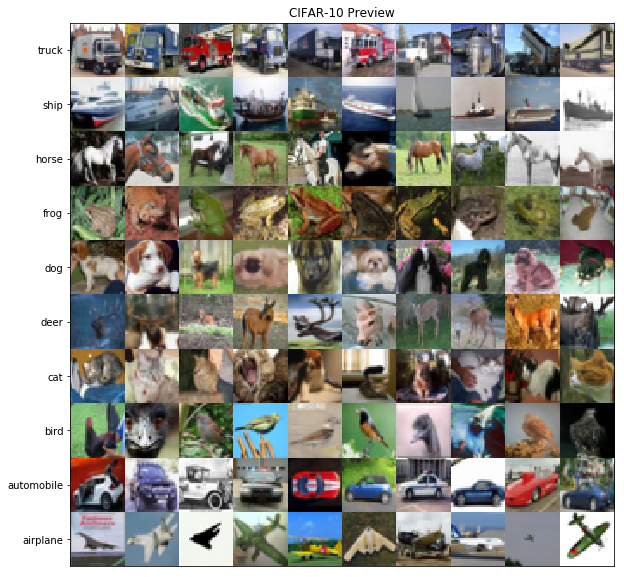

In [3]:
# Preview dataset

_ = plt.figure(figsize=(10, 10))
_ = plt.title('CIFAR-10 Preview')
for label_index, label_name in enumerate(label_names):
    for img_index, img_data in enumerate(test_data[test_labels == label_index][:10]):
        _ = plt.imshow(
            np.moveaxis(np.reshape(img_data, (3, 32, 32)), 0, 2),
            interpolation='nearest', extent=[img_index, img_index + 1, label_index, label_index + 1])
_ = plt.xticks([])
_ = plt.yticks(np.arange(len(label_names)) + 0.5, label_names)
_ = plt.xlim(0, 10)
_ = plt.ylim(0, len(label_names))

In [4]:
# Keep only 2 categories and remove all others from both image data and labels

active_label_indices = [0, 1]

print('\nTaking subset of label names ...')
label_names = [label_names[label_index] for label_index in active_label_indices]
print('label_names:', label_names)

print('\nTaking subset of train set ...')
train_data = train_data[np.any(train_labels[:, None] == active_label_indices, axis=-1)]
train_labels = train_labels[np.any(train_labels[:, None] == active_label_indices, axis=-1)]
print(f'train_data: <np.array of shape: {train_data.shape} dtype: {train_data.dtype}>')
print(f'train_labels: <np.array of shape: {train_labels.shape} dtype: {train_labels.dtype}>')

print('\nTaking subset of test set ...')
test_data = test_data[np.any(test_labels[:, None] == active_label_indices, axis=-1)]
test_labels = test_labels[np.any(test_labels[:, None] == active_label_indices, axis=-1)]
print(f'test_data: <np.array of shape: {test_data.shape} dtype: {test_data.dtype}>')
print(f'test_labels: <np.array of shape: {test_labels.shape} dtype: {test_labels.dtype}>')



Taking subset of label names ...
label_names: ['airplane', 'automobile']

Taking subset of train set ...
train_data: <np.array of shape: (10000, 3072) dtype: float32>
train_labels: <np.array of shape: (10000,) dtype: int32>

Taking subset of test set ...
test_data: <np.array of shape: (2000, 3072) dtype: float32>
test_labels: <np.array of shape: (2000,) dtype: int32>


## 2. Training

loss 7.953 acc 0.500:   2%|██▎                                                                                           | 60/2500 [00:00<00:04, 600.00it/s]

  - test acc: 0.656


loss 7.800 acc 0.750:   3%|██▎                                                                                           | 63/2500 [00:00<00:03, 623.75it/s]

  - test acc: 0.695


loss 7.755 acc 0.750:   3%|██▌                                                                                           | 67/2500 [00:00<00:03, 663.38it/s]

  - test acc: 0.715


loss 7.648 acc 1.000:   3%|██▍                                                                                           | 64/2500 [00:00<00:03, 633.67it/s]

  - test acc: 0.728


loss 7.607 acc 1.000:   3%|██▍                                                                                           | 65/2500 [00:00<00:03, 643.58it/s]

  - test acc: 0.739


loss 7.624 acc 0.750:   3%|██▎                                                                                           | 63/2500 [00:00<00:03, 617.65it/s]

  - test acc: 0.750


loss 7.581 acc 1.000:   2%|██▏                                                                                           | 59/2500 [00:00<00:04, 584.14it/s]

  - test acc: 0.758


loss 7.722 acc 0.500:   3%|██▎                                                                                           | 63/2500 [00:00<00:03, 629.99it/s]

  - test acc: 0.764


loss 7.617 acc 0.750:   2%|██▎                                                                                           | 62/2500 [00:00<00:03, 613.88it/s]

  - test acc: 0.769


loss 7.583 acc 0.750:   3%|██▍                                                                                           | 65/2500 [00:00<00:03, 643.57it/s]

  - test acc: 0.768


loss 7.579 acc 0.750:   2%|██▎                                                                                           | 61/2500 [00:00<00:04, 603.96it/s]

  - test acc: 0.771


loss 7.630 acc 0.500:   2%|██▎                                                                                           | 62/2500 [00:00<00:03, 613.86it/s]

  - test acc: 0.771


loss 7.454 acc 1.000:   2%|██▎                                                                                           | 61/2500 [00:00<00:04, 597.97it/s]

  - test acc: 0.774


loss 7.449 acc 1.000:   2%|██▏                                                                                           | 57/2500 [00:00<00:04, 569.99it/s]

  - test acc: 0.778


loss 7.486 acc 0.750:   2%|██                                                                                            | 54/2500 [00:00<00:04, 534.66it/s]

  - test acc: 0.780


loss 7.517 acc 0.500:   2%|██▏                                                                                           | 57/2500 [00:00<00:04, 569.98it/s]

  - test acc: 0.781


loss 7.395 acc 1.000:   2%|██▏                                                                                           | 59/2500 [00:00<00:04, 584.14it/s]

  - test acc: 0.784


loss 7.470 acc 0.750:   2%|██▎                                                                                           | 60/2500 [00:00<00:04, 594.06it/s]

  - test acc: 0.786


loss 7.484 acc 0.750:   2%|██▎                                                                                           | 61/2500 [00:00<00:04, 603.97it/s]

  - test acc: 0.786


loss 7.413 acc 0.750:   2%|██▎                                                                                           | 60/2500 [00:00<00:04, 594.06it/s]

  - test acc: 0.786


loss 7.435 acc 0.750:   2%|██▎                                                                                           | 61/2500 [00:00<00:04, 603.96it/s]

  - test acc: 0.788


loss 7.363 acc 1.000:   2%|██▎                                                                                           | 62/2500 [00:00<00:03, 613.87it/s]

  - test acc: 0.789


loss 7.400 acc 0.750:   3%|██▍                                                                                           | 64/2500 [00:00<00:03, 633.68it/s]

  - test acc: 0.790


loss 7.393 acc 0.750:   2%|██▎                                                                                           | 60/2500 [00:00<00:04, 594.06it/s]

  - test acc: 0.791


loss 7.362 acc 0.750:   1%|▉                                                                                             | 26/2500 [00:00<00:10, 242.98it/s]

  - test acc: 0.792


loss 7.423 acc 0.750:   2%|██▎                                                                                           | 60/2500 [00:00<00:04, 594.05it/s]

  - test acc: 0.793


loss 7.345 acc 0.750:   2%|██▏                                                                                           | 58/2500 [00:00<00:04, 579.97it/s]

  - test acc: 0.794


loss 7.351 acc 0.750:   2%|█▉                                                                                            | 53/2500 [00:00<00:04, 530.00it/s]

  - test acc: 0.796


loss 7.280 acc 1.000:   2%|██▎                                                                                           | 61/2500 [00:00<00:04, 598.03it/s]

  - test acc: 0.798


loss 7.299 acc 1.000:   2%|██▏                                                                                           | 59/2500 [00:00<00:04, 584.16it/s]

  - test acc: 0.798


loss 7.391 acc 0.750:   2%|██▎                                                                                           | 61/2500 [00:00<00:04, 598.05it/s]

  - test acc: 0.798


loss 7.437 acc 0.500:   2%|██▏                                                                                           | 59/2500 [00:00<00:04, 584.15it/s]

  - test acc: 0.800


loss 7.331 acc 0.750:   2%|██▏                                                                                           | 58/2500 [00:00<00:04, 580.00it/s]

  - test acc: 0.800


loss 7.295 acc 0.750:   2%|██▏                                                                                           | 57/2500 [00:00<00:04, 564.33it/s]

  - test acc: 0.801


loss 7.250 acc 1.000:   2%|█▍                                                                                            | 39/2500 [00:00<00:06, 382.36it/s]

  - test acc: 0.802


loss 7.252 acc 1.000:   2%|██▎                                                                                           | 61/2500 [00:00<00:04, 603.96it/s]

  - test acc: 0.803


loss 7.246 acc 1.000:   2%|██▏                                                                                           | 57/2500 [00:00<00:04, 564.35it/s]

  - test acc: 0.804


loss 7.361 acc 0.750:   2%|██▎                                                                                           | 62/2500 [00:00<00:03, 619.99it/s]

  - test acc: 0.804


loss 7.360 acc 0.750:   2%|██                                                                                            | 55/2500 [00:00<00:04, 549.98it/s]

  - test acc: 0.803


loss 7.301 acc 0.750:   2%|██▏                                                                                           | 57/2500 [00:00<00:04, 564.36it/s]

  - test acc: 0.803


loss 7.299 acc 0.750:   2%|██▏                                                                                           | 58/2500 [00:00<00:04, 574.25it/s]

  - test acc: 0.804


loss 7.376 acc 0.500:   2%|██▏                                                                                           | 57/2500 [00:00<00:04, 570.00it/s]

  - test acc: 0.804


loss 7.398 acc 0.500:   2%|██                                                                                            | 56/2500 [00:00<00:04, 554.46it/s]

  - test acc: 0.804


loss 7.253 acc 1.000:   2%|██▏                                                                                           | 59/2500 [00:00<00:04, 590.00it/s]

  - test acc: 0.804


loss 7.396 acc 0.500:   2%|██▏                                                                                           | 57/2500 [00:00<00:04, 569.99it/s]

  - test acc: 0.804


loss 7.267 acc 0.750:   2%|██                                                                                            | 54/2500 [00:00<00:04, 539.99it/s]

  - test acc: 0.805


loss 7.235 acc 1.000:   2%|██▏                                                                                           | 58/2500 [00:00<00:04, 574.26it/s]

  - test acc: 0.805


loss 7.395 acc 0.500:   2%|██▏                                                                                           | 57/2500 [00:00<00:04, 564.34it/s]

  - test acc: 0.806


loss 7.245 acc 1.000:   2%|██▏                                                                                           | 58/2500 [00:00<00:04, 574.26it/s]

  - test acc: 0.806


loss 7.246 acc 1.000:   2%|██                                                                                            | 56/2500 [00:00<00:04, 554.46it/s]

  - test acc: 0.806


loss 7.247 acc 1.000:   2%|██▎                                                                                           | 61/2500 [00:00<00:04, 598.06it/s]

  - test acc: 0.807


loss 7.247 acc 1.000:   2%|██                                                                                            | 56/2500 [00:00<00:04, 554.46it/s]

  - test acc: 0.808


loss 7.241 acc 1.000:   2%|██▏                                                                                           | 59/2500 [00:00<00:04, 578.45it/s]

  - test acc: 0.807


loss 7.361 acc 0.750:   2%|██▏                                                                                           | 57/2500 [00:00<00:04, 564.35it/s]

  - test acc: 0.805


loss 7.364 acc 0.750:   2%|██                                                                                            | 56/2500 [00:00<00:04, 554.44it/s]

  - test acc: 0.804


loss 7.405 acc 0.500:   2%|██                                                                                            | 55/2500 [00:00<00:04, 544.54it/s]

  - test acc: 0.805


loss 7.322 acc 0.750:   2%|██▏                                                                                           | 58/2500 [00:00<00:04, 574.27it/s]

  - test acc: 0.806


loss 7.325 acc 0.750:   2%|██▏                                                                                           | 57/2500 [00:00<00:04, 564.36it/s]

  - test acc: 0.807


loss 7.269 acc 1.000:   2%|██                                                                                            | 55/2500 [00:00<00:04, 539.21it/s]

  - test acc: 0.807


loss 7.382 acc 0.750:   2%|██                                                                                            | 56/2500 [00:00<00:04, 557.09it/s]

  - test acc: 0.807


loss 7.300 acc 0.750:   2%|██                                                                                            | 55/2500 [00:00<00:04, 550.00it/s]

  - test acc: 0.807


loss 7.391 acc 0.750:   2%|██▏                                                                                           | 57/2500 [00:00<00:04, 564.35it/s]

  - test acc: 0.808


loss 7.310 acc 0.750:   2%|██▏                                                                                           | 57/2500 [00:00<00:04, 564.36it/s]

  - test acc: 0.808


loss 7.368 acc 0.500:   2%|██                                                                                            | 55/2500 [00:00<00:04, 539.23it/s]

  - test acc: 0.807


loss 7.369 acc 0.750:   2%|██                                                                                            | 54/2500 [00:00<00:04, 539.97it/s]

  - test acc: 0.807


loss 7.350 acc 0.750:   2%|██                                                                                            | 54/2500 [00:00<00:04, 539.99it/s]

  - test acc: 0.807


loss 7.363 acc 0.750:   2%|██                                                                                            | 55/2500 [00:00<00:04, 549.99it/s]

  - test acc: 0.808


loss 7.376 acc 0.750:   2%|█▉                                                                                            | 52/2500 [00:00<00:04, 514.86it/s]

  - test acc: 0.808


loss 7.447 acc 0.500:   2%|██▏                                                                                           | 59/2500 [00:00<00:04, 589.99it/s]

  - test acc: 0.808


loss 7.330 acc 1.000:   2%|██                                                                                            | 54/2500 [00:00<00:04, 529.42it/s]

  - test acc: 0.808


loss 7.477 acc 0.500:   2%|██▏                                                                                           | 57/2500 [00:00<00:04, 564.37it/s]

  - test acc: 0.809


loss 7.476 acc 0.750:   2%|█▉                                                                                            | 52/2500 [00:00<00:04, 514.84it/s]

  - test acc: 0.809


loss 7.398 acc 0.750:   2%|██                                                                                            | 55/2500 [00:00<00:04, 544.56it/s]

  - test acc: 0.810


loss 7.500 acc 0.500:   2%|██                                                                                            | 56/2500 [00:00<00:04, 549.01it/s]

  - test acc: 0.810


loss 7.414 acc 0.750:   2%|█▉                                                                                            | 52/2500 [00:00<00:04, 520.00it/s]

  - test acc: 0.809


loss 7.402 acc 0.750:   2%|██                                                                                            | 56/2500 [00:00<00:04, 554.46it/s]

  - test acc: 0.810


loss 7.518 acc 0.750:   2%|█▉                                                                                            | 50/2500 [00:00<00:04, 499.93it/s]

  - test acc: 0.810


loss 7.397 acc 1.000:   2%|██▏                                                                                           | 57/2500 [00:00<00:04, 569.99it/s]

  - test acc: 0.810


loss 7.407 acc 1.000:   2%|██                                                                                            | 54/2500 [00:00<00:04, 534.65it/s]

  - test acc: 0.812


loss 7.493 acc 0.750:   2%|█▉                                                                                            | 52/2500 [00:00<00:04, 514.84it/s]

  - test acc: 0.812


loss 7.438 acc 1.000:   1%|▊                                                                                             | 20/2500 [00:00<00:12, 196.08it/s]

  - test acc: 0.812


loss 7.513 acc 0.750:   2%|█▉                                                                                            | 50/2500 [00:00<00:04, 500.00it/s]

  - test acc: 0.812


loss 7.535 acc 0.500:   2%|██                                                                                            | 54/2500 [00:00<00:04, 534.66it/s]

  - test acc: 0.814


loss 7.535 acc 0.750:   2%|█▉                                                                                            | 51/2500 [00:00<00:04, 504.95it/s]

  - test acc: 0.813


loss 7.546 acc 0.750:   2%|█▉                                                                                            | 52/2500 [00:00<00:04, 514.86it/s]

  - test acc: 0.813


loss 7.576 acc 0.750:   2%|█▉                                                                                            | 51/2500 [00:00<00:04, 510.00it/s]

  - test acc: 0.814


loss 7.637 acc 0.750:   2%|█▉                                                                                            | 52/2500 [00:00<00:04, 520.00it/s]

  - test acc: 0.815


loss 7.568 acc 1.000:   2%|█▉                                                                                            | 50/2500 [00:00<00:04, 495.03it/s]

  - test acc: 0.815


loss 7.753 acc 0.250:   2%|█▊                                                                                            | 48/2500 [00:00<00:05, 472.80it/s]

  - test acc: 0.815


loss 7.780 acc 0.250:   2%|█▊                                                                                            | 48/2500 [00:00<00:05, 475.24it/s]

  - test acc: 0.817


loss 7.581 acc 1.000:   2%|█▊                                                                                            | 48/2500 [00:00<00:05, 479.99it/s]

  - test acc: 0.818


loss 7.670 acc 0.750:   2%|█▉                                                                                            | 52/2500 [00:00<00:04, 509.80it/s]

  - test acc: 0.818


loss 7.714 acc 0.750:   2%|█▉                                                                                            | 52/2500 [00:00<00:04, 504.87it/s]

  - test acc: 0.818


loss 7.729 acc 0.750:   2%|█▉                                                                                            | 51/2500 [00:00<00:04, 504.96it/s]

  - test acc: 0.818


loss 7.716 acc 0.750:   2%|█▉                                                                                            | 53/2500 [00:00<00:04, 530.00it/s]

  - test acc: 0.817


loss 7.682 acc 1.000:   2%|█▊                                                                                            | 49/2500 [00:00<00:05, 480.39it/s]

  - test acc: 0.817


loss 7.722 acc 0.750: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:05<00:00, 483.55it/s]


  - test acc: 0.818


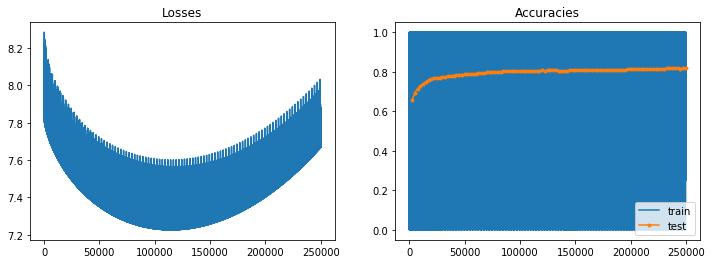

In [8]:
# You may freely modify any given template code as you see fit.

batch_size = 4
max_epoch = 100
lr = 0.0002    # learning rate
lam = 0.03   # lambda for regularization

np.random.seed(42)
W = np.random.rand(1,3072) - 0.5     # weight
b = np.random.rand(1)[0] - 0.5   # bias


def apply_h(x):
    wxb = np.matmul(W,x.transpose()) + b
    denom = np.exp((-1) * wxb) + 1
    return 1 / denom

def calc_loss(y_pred_probs, y_true):
    reg_term = np.matmul(W, W.transpose())[0][0]
    return np.power(y_pred_probs - y_true, 2).mean() / 2 + (lam * reg_term)

def calc_grad_w(x, y_pred_probs, y_true):
    return np.matmul((y_pred_probs - y_true), x) + lam * np.power(W, 2) / 2

def calc_grad_b(x, y_pred_probs, y_true):
    return np.sum(y_pred_probs - y_true)
    
losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(max_epoch):
    steps_per_epoch = np.ceil(len(train_data) / batch_size).astype(int)
    progress_bar = tqdm.tqdm(range(steps_per_epoch), position=0, leave=True)
    for step_index in progress_bar:
        # fetch next batch of training data
        x = train_data[step_index * batch_size:(step_index + 1) * batch_size]           # train_data as x (shape: [batch_size, 3072])
        y_true = train_labels[step_index * batch_size:(step_index + 1) * batch_size]    # train_labels as y (shape: [batch_size,])
        y_true = (y_true != active_label_indices[0]).astype(int)                        # make binary

        # prediction
        y_pred_probs = apply_h(x)   # h(x) in the slides
        y_pred = 1 * (y_pred_probs >= 0.5)

        # calculate loss & accuracy
        loss = calc_loss(y_pred_probs, y_true)
        accuracy = np.sum(y_pred == y_true) / batch_size

        losses.append(loss)
        train_accuracies.append(accuracy)
        progress_bar.set_description(f'loss {loss:.3f} acc {accuracy:.3f}')

        # update weights
        grad_W = calc_grad_w(x, y_pred_probs, y_true)
        grad_b = calc_grad_b(x, y_pred_probs, y_true)
        W = W - grad_W * lr
        b = b - grad_b * lr # keep in mind that we don't apply regularization to bias

    # test accuracies
    x = test_data
    y_true = test_labels
    y_true = (y_true != active_label_indices[0]).astype(int)    # make binary

    # test prediction
    y_pred_probs = apply_h(x)    # h(x) in the slides
    y_pred = 1 * (y_pred_probs >= 0.5)

    # calculate accuracy
    accuracy = np.sum(y_pred == y_true) / len(y_true)
    test_accuracies.append(accuracy)
    print(f'  - test acc: {accuracy:.3f}')

# plot loss & accuracy curve
fig, (a0, a1) = plt.subplots(1, 2, figsize=(12, 4))
_ = a0.set_title('Losses')
_ = a0.plot(losses)
_ = a1.set_title('Accuracies')
_ = a1.plot(train_accuracies, label='train')
_ = a1.plot((np.arange(max_epoch) + 1) * steps_per_epoch, test_accuracies, marker='.', label='test')
_ = a1.legend()


## 3. Report

The first and most obvious observation is that the performance increases over time, as can be seen from the rising test accuracy. This proves that the classifier was set up correctly and that the gradient descent algorithm is effective at training the classifier.

In general a smaller learning rate gave rise to better results since smaller learning rates are able to better reach the local minima of the loss functions. However smaller learning rates also take longer to converge, so we need to compensate by increasing the number of epochs. Since we are only performing logistic regression and not training an entire neural network, it is quite fast to finish one epoch, hence a small learning rate gives us noticeable benefits with a very small cost.

Similar to the above, a smaller batch size increased the time required for training with a fixed number of epochs. That is because the duration of each epoch was increased, since the gradient had to be calculated more often. However with a smaller batch size the magnitude of the gradient was also smaller. Overall it was observed that, with respect to the number of epochs, a large batch size resulted in faster improvement early on, but it converged to a lower final performance in the end.

We hence found a compromise in the following parameters:
**batch_size = 4, max_epoch = 100, lr = 0.0002**

For lambda we tried a few different possible values, using the above hyperparameters. The final test accuracies are shown below:
* lam = 0 (no regularization)                -> acc = 0.816
*lam = 0.0001                               -> acc = 0.816
*lam = 0.001                                -> acc = 0.816
*lam = 0.01 -> acc = 0.816
* **lam = 0.03 -> acc = 0.818**
*lam = 0.05 -> acc = 0.811
*lam = 0.1 -> acc = 0.500
*lam = 1                                    -> acc = 0.500

When regularization is too high, the weights are pushed towards being all zero, so the final performance ends up becoming a 50/50 guess, leading to 0.5 accuracy. When regularization is low, the model risks overfitting. However, we should note that the model is a simple logistic regression model, which has low capacity. As a result the tendency to overfit is also quite low. Therefore the benefits of regularization are generally quite small. With no regularization the test accuracy is 0.816. The best accuracy we could achieve with regularization was 0.818 when lambda = 0.03; this is an improvement but it is still quite a small difference.

A very interesting observation is that the training loss seems to go down initially, but then go up again after about 100000 iterations. This is likely caused by the regularization since it prevents the model from overfitting to the training set, hence the performance on the training set might be lower. Nonetheless the test accuracy still continued to improve as expected, so this was not an issue.